# Linear layer

## <식1>
- 1단계: (4, 2) x (2, 1) 행렬 = (4, )
- 2단계: (4, ) x (4, 1) 행렬 = (1, )

In [1]:
import tensorflow as tf

batch_size = 64
# Tensorflow는 Batch를 기반으로 동작하기에
# 사각형 2개 세트를 batch_size개만큼 만든 후 처리를 하게 됨.
boxes = tf.zeros((batch_size, 4, 2))     

print("1단계 연산 준비:", boxes.shape)

first_linear = tf.keras.layers.Dense(units=1, use_bias=False) 
# units은 출력 차원 수를 의미합니다.
# Weight 행렬 속 실수를 인간의 뇌 속 하나의 뉴런 '유닛' 취급을 하는 거죠!

first_out = first_linear(boxes)
first_out = tf.squeeze(first_out, axis=-1) # (4, 1)을 (4,)로 변환해줍니다.
                                           # (불필요한 차원 축소)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4)
1단계 Linear Layer의 Weight 형태: (2, 1)

2단계 연산 준비: (64, 4)
2단계 연산 결과: (64,)
2단계 Linear Layer의 Weight 형태: (4, 1)


- 2차원을 1차원으로 변환하는 데에 (2, 1) 혹은 (2 x 1) 행렬이 하나 선언되고, 4차원을 1차원으로 변환하는 데에 (4, 1) 혹은 (4 x 1) 행렬이 하나 선언됨에 유의
- 여기서 각각의 행렬들이 Weight
- Linear 레이어는 (입력의 차원, 출력의 차원)에 해당하는 Weight를 가지는 특성
![result](https://d3s0tskafalll9.cloudfront.net/media/images/F-24-7.max-800x600.png)
  - 두 사각형에 대해 1단계를 거치고 난 결과가 동일
  -  이렇게 되면 <식 1>의 2단계 입력이 동일해지니 두 번째 (4 x 1) Weight를 거치는 것이 의미가 없어짐. 
  - 파라미터로 해결하기엔 역부족. 데이터를 더 풍부하게 만드는 방법 시도 해야 함.

## <식2>
- 1단계: (4, 2) x (2 x 3) 행렬 = (4, 3)
- 2단계: (4, 3) x (3 x 1) 행렬 = (4, )
- 3단계: (4, ) x (4 x 1) 행렬 = (1, )

In [3]:
import tensorflow as tf

batch_size = 64
boxes = tf.zeros((batch_size, 4, 2))

print("1단계 연산 준비:", boxes.shape)

# Step 1: (4,2)차원인 boxes를 (4,3)으로 확장시키는 Linear Layer를 활용.
first_linear = tf.keras.layers.Dense(units=3, use_bias=False)
first_out = first_linear(boxes)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

# Dense = Linear
second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

print("\n3단계 연산 준비:", second_out.shape)

# Step 2: 4차원인 second_out을 하나의 실수으로 집약시키는 Linear Layer를 활용.
third_linear = tf.keras.layers.Dense(units=1, use_bias=False)
third_out = third_linear(second_out)
third_out = tf.squeeze(third_out, axis=-1)

print("3단계 연산 결과:", third_out.shape)
print("3단계 Linear Layer의 Weight 형태:", third_linear.weights[0].shape)

# Step 3: 모든 params를 더하여 total_parmams 구함.
total_params = \
first_linear.count_params() + \
second_linear.count_params() + \
third_linear.count_params()

print("총 Parameters:", total_params)

1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4, 3)
1단계 Linear Layer의 Weight 형태: (2, 3)

2단계 연산 준비: (64, 4, 3)
2단계 연산 결과: (64, 4)
2단계 Linear Layer의 Weight 형태: (3, 1)

3단계 연산 준비: (64, 4)
3단계 연산 결과: (64,)
3단계 Linear Layer의 Weight 형태: (4, 1)
총 Parameters: 13


![result2](https://d3s0tskafalll9.cloudfront.net/media/images/F-24-8.max-800x600.png)
  - 1단계의 결과로 각 사각형에 대해 독립적인 정보가 생겨나기 시작
  -  <식 2>는 첫 번째 접근에 비해 더 많은 사각형을 구분해낼 수 있음.

## Bias(편향)
- 편향이 없다면 파라미터를 아무리 돌리고 늘리고 해도 정확하게 근사할 수 없음.
- 단순히 생각해서 원점을 평행이동하는 것만으로도 해결할 수 있기 때문에 실제로 편향은 선형변환된 값에 편향 파라미터 b를 더해주는 것으로 표현.
-  y = Wx + b 속의 b 가 바로 그 편향 값.
- 편향 값은 형태가 (선형변환 결과 차원, ) 인 한 줄짜리 Weight로 정의.

In [4]:
import tensorflow as tf

batch_size = 64
# Tensorflow는 Batch를 기반으로 동작하기에
# 사각형 2개 세트를 batch_size개만큼 만든 후 처리를 하게 됨.
boxes = tf.zeros((batch_size, 4, 2))     

print("1단계 연산 준비:", boxes.shape)

first_linear = tf.keras.layers.Dense(units=1, use_bias=True) 
# units은 출력 차원 수를 의미합니다.
# Weight 행렬 속 실수를 인간의 뇌 속 하나의 뉴런 '유닛' 취급을 하는 거죠!

first_out = first_linear(boxes)
first_out = tf.squeeze(first_out, axis=-1) # (4, 1)을 (4,)로 변환해줍니다.
                                           # (불필요한 차원 축소)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

second_linear = tf.keras.layers.Dense(units=1, use_bias=True)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4)
1단계 Linear Layer의 Weight 형태: (2, 1)

2단계 연산 준비: (64, 4)
2단계 연산 결과: (64,)
2단계 Linear Layer의 Weight 형태: (4, 1)


# Convolution layer

In [3]:
import tensorflow as tf
"""
"batch_size = 64
pic = tf.zeros((batch_size, 1920, 1080, 3))

print("입력 이미지 데이터:", pic.shape)
conv_layer = tf.keras.layers.Conv2D(filters=16,
                                    kernel_size=(5, 5),
                                    strides=5,
                                    use_bias=False)
conv_out = conv_layer(pic)

print("\nConvolution 결과:", conv_out.shape)
print("Convolution Layer의 Parameter 수:", conv_layer.count_params())

flatten_out = tf.keras.layers.Flatten()(conv_out)
print("\n1차원으로 펼친 데이터:", flatten_out.shape)

linear_layer = tf.keras.layers.Dense(units=1, use_bias=False)
linear_out = linear_layer(flatten_out)

print("\nLinear 결과:", linear_out.shape)
print("Linear Layer의 Parameter 수:", linear_layer.count_params())
"
"""

'\n"batch_size = 64\npic = tf.zeros((batch_size, 1920, 1080, 3))\n\nprint("입력 이미지 데이터:", pic.shape)\nconv_layer = tf.keras.layers.Conv2D(filters=16,\n                                    kernel_size=(5, 5),\n                                    strides=5,\n                                    use_bias=False)\nconv_out = conv_layer(pic)\n\nprint("\nConvolution 결과:", conv_out.shape)\nprint("Convolution Layer의 Parameter 수:", conv_layer.count_params())\n\nflatten_out = tf.keras.layers.Flatten()(conv_out)\nprint("\n1차원으로 펼친 데이터:", flatten_out.shape)\n\nlinear_layer = tf.keras.layers.Dense(units=1, use_bias=False)\nlinear_out = linear_layer(flatten_out)\n\nprint("\nLinear 결과:", linear_out.shape)\nprint("Linear Layer의 Parameter 수:", linear_layer.count_params())\n"\n'

- 위의 코드를 실행시키면 GPU 에러가 뜸.
- ResourceExhaustedError: OOM when allocating tensor with shape[64,1920,1080,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]
- 위와 같은 에러 메세지가 뜨고, 배치 사이즈를 줄여도 같은 에러가 나는 걸로 봐서는 GPU 메모리 문제 같은데 해결 법을 알 수가 없어 일단 주석처리 하고 넘어감..
- 이미지 사이즈를 (100,100,3)으로 줄이니까 배치사이즈 1일 때만 에러 없이 잘 실행 됨.

# Pooling layer
## - Receptive Field
- Neural Network의 출력부가 충분한 정보를 얻기 위해 커버하는 입력 데이터의 Receptive Field가 충분히 커서 그 안에 detect해야 할 object의 특성이 충분히 포함되어 있어야 정확한 detection이 가능하게 됨.
## - Max Pooling layer
- 효과적으로 Receptive Field를 키우고, 정보 집약 효과를 극대화할 수 있음.
### - translational invariance 효과
- , Max Pooling을 통해 인접한 영역 중 가장 특징이 두드러진 영역 하나를 뽑는 것은 오히려 약간의 시프트 효과에도 불구하고 동일한 특징을 안정적으로 잡아낼 수 있는 긍정적 효과가 있음.
- 오히려 object 위치에 대한 오버피팅을 방지하고 안정적인 특징 추출 효과.
### - Non-linear 함수와 동일한 피처 추출 효과
- Relu와 같은 Non-linear 함수도 마찬가지로 많은 하위 레이어의 연산 결과를 무시하는 효과를 발생시키지만, 그 결과 중요한 피처만을 상위 레이어로 추출해서 올려줌으로써 결과적으로 분류기의 성능을 증진시키는 효과.
- in/Max Pooling도 이와 동일한 효과를 가지게 됨.
### - Receptive Field 극대화 효과
- Max Pooling이 없이도 Receptive Field를 크게 하려면 Convolutional 레이어를 아주 많이 쌓아야.
- 큰 파라미터 사이즈로 인한 오버피팅, 연산량 증가, Gradient Vanishing 등의 문제를 감수해야 함.
- 이런 문제를 효과적으로 해결하는 방법으로 꼽히는 두 가지 중 하나가 Max Pooling 레이어 사용과 다른 하나로는 Dilated Convolution.

# Deconvolution layer
- Convolution의 결과를 역재생해서 원본 이미지와 최대한 유사한 정보를 복원해 내는 Auto Encoder.

## - MNIST 데이터셋을 입력으로 받아 그대로 복원하는 Auto Encoder
- 패키지 임포트 및 MNIST 데이터셋 로딩
- AutoEncoder 모델 구성
- AutoEncoder 모델 훈련
- AutoEncoder Reconstruction Test

In [4]:
import numpy as np
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.datasets import mnist
import json
import matplotlib.pyplot as plt #for plotting

# MNIST 데이터 로딩
(x_train, _), (x_test, _) = mnist.load_data()    # y_train, y_test는 사용하지 않습니다.

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

- AutoEncoder가 수행하는 Image Reconstruction Task는 x_train의 라벨이 바로 x_train 자신이 되기 때문에 y_train, y_test를 사용하지 않음.

In [5]:
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
encode_pool_layer_1 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
encode_pool_layer_2 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu', padding='same')
encode_pool_layer_3 = MaxPooling2D((2, 2), padding='same')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)
encoded = encode_pool_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분
decode_conv_layer_1 = Conv2D(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 4)           0     

- Conv2D 레이어는 shape를 변화시키지 않고 있음.
- Output shape를 변화시키는 것은 오롯이 MaxPooling2D 레이어의 역할.
- 그래서 Encoder를 통과한 직후의 Output은 4 X 4 의 shape가 됨.

In [6]:
#AutoEncoder를 훈련
# y_train이 들어가야 할 자리에 x_train이 들어가 있음을 유의.
# loss로 주로 분류 모델에서 사용되는 binary_crossentropy를 사용.
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 20s 54ms/step - loss: 0.6876 - val_loss: 0.6868
Epoch 2/50
235/235 [==============================] - 6s 25ms/step - loss: 0.6864 - val_loss: 0.6854
Epoch 3/50
235/235 [==============================] - 6s 25ms/step - loss: 0.6849 - val_loss: 0.6836
Epoch 4/50
235/235 [==============================] - 6s 24ms/step - loss: 0.6830 - val_loss: 0.6813
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 0.6806 - val_loss: 0.6784
Epoch 6/50
235/235 [==============================] - 6s 25ms/step - loss: 0.6774 - val_loss: 0.6746
Epoch 7/50
235/235 [==============================] - 6s 24ms/step - loss: 0.6733 - val_loss: 0.6693
Epoch 8/50
235/235 [==============================] - 6s 24ms/step - loss: 0.6675 - val_loss: 0.6618
Epoch 9/50
235/235 [==============================] - 6s 25ms/step - loss: 0.6592 - val_loss: 0.6505
Epoch 10/50
235/235 [==============================] - 6s 25ms/step - loss: 0.6462 - val_l

- loss로 주로 분류 모델에서 사용되는 binary_crossentropy를 사용한 것에 대해
  - 모든 dim에서 0~1 사이의 값을 가지는 입력 데이터와 출력 데이터(마지막 출력이 sigmoid로 제어되고 있음에 유의) 사이의 분포가 최대한 유사하기를 바라기 때문에 이 loss는 타당함.

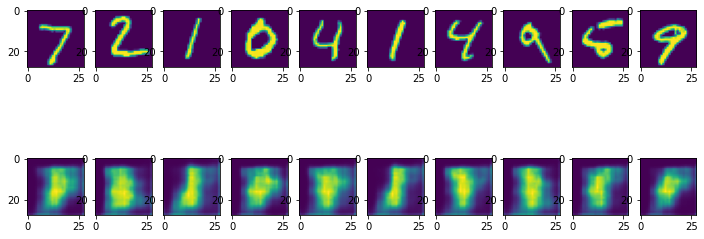

In [7]:
#실제로 우리가 만든 AutoEncoder가 MNIST 이미지를 제대로 생성하는지를 확인

x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])

- 일한 Decoder 네트워크 구조를 가지고도 Variational Autoencoder나 DCGAN 등은 훨씬 훌륭한 이미지를 생성하기 때문에, 이것은 Decoder 네트워크 구조만의 문제는 아닐 것.

## - Transposed Convolution

In [8]:
from tensorflow.python.keras.layers import Conv2DTranspose

# Conv2DTranspose를 활용한  AutoEncoder 모델
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu')
encode_pool_layer_1 = MaxPooling2D((2, 2))
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu')
encode_pool_layer_2 = MaxPooling2D((2, 2))
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분  - 
decode_conv_layer_1 = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2DTranspose(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 4)           292       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 4)           148 

In [9]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 73s 185ms/step - loss: 0.6973 - val_loss: 0.6964
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.6962 - val_loss: 0.6954
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.6951 - val_loss: 0.6943
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.6940 - val_loss: 0.6932
Epoch 5/50
235/235 [==============================] - 3s 13ms/step - loss: 0.6929 - val_loss: 0.6920
Epoch 6/50
235/235 [==============================] - 3s 12ms/step - loss: 0.6917 - val_loss: 0.6907
Epoch 7/50
235/235 [==============================] - 3s 13ms/step - loss: 0.6903 - val_loss: 0.6893
Epoch 8/50
235/235 [==============================] - 3s 12ms/step - loss: 0.6889 - val_loss: 0.6878
Epoch 9/50
235/235 [==============================] - 3s 13ms/step - loss: 0.6873 - val_loss: 0.6861
Epoch 10/50
235/235 [==============================] - 3s 12ms/step - loss: 0.6857 - val_

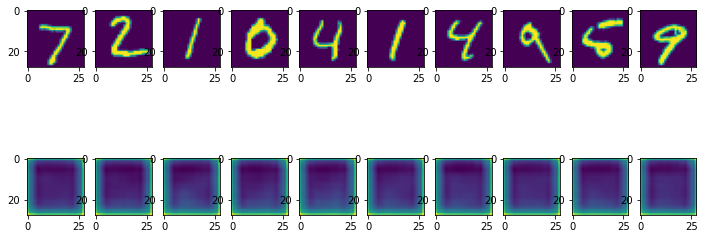

In [10]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])